In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn import metrics
from einops import rearrange

In [2]:
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

class WheelRailTrajectoryDataset:
    def __init__(self,label=3):
        standard_scaler = StandardScaler()
        self.raw_data1 = pd.read_csv("../dataset/curve_R400.csv")
        self.raw_data2 = pd.read_csv("../dataset/curve_R1000.csv")
        self.raw_data3 = pd.read_csv("../dataset/curve_R2000.csv")
        self.raw_data4 = pd.read_csv("../dataset/curve_R3000.csv")
        self.raw_data5 = pd.read_csv("../dataset/curve_R4000.csv")
        self.raw_data6 = pd.read_csv("../dataset/curve_R5000.csv")
        self.raw_data = pd.concat([self.raw_data1,self.raw_data2,self.raw_data3,self.raw_data4,self.raw_data5,self.raw_data6])
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(self.raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])


    def construct_set(self, train_por=0.6,val_por=0.2,test_por=0.2, window_size=100):
        X = []
        Y = []
        list = [self.raw_data1.shape[0],self.raw_data2.shape[0],self.raw_data3.shape[0],self.raw_data4.shape[0],self.raw_data5.shape[0],self.raw_data6.shape[0]]
        num = 0
        for j in range(len(list)):
            if j!=0:
                num = num+list[j-1]
            for i in range(list[j]-window_size):
                seq = self.data[num+i:num+i+window_size+1]
                X.append(seq[0:window_size,:self.label])
                y = seq[window_size:window_size+1,self.label]
                if(y>0.6 or y<-0.6):
                    Y.append(1)
                else:
                    Y.append(0)
        X = np.array(X)
        Y = np.array(Y)
        print(X.shape)
        print(Y.shape)
        train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=test_por,train_size=train_por+val_por,shuffle=True)
        train_x,val_x,train_y,val_y =  train_test_split(train_x,train_y,test_size=val_por/(val_por+train_por),train_size=train_por/(val_por+train_por),shuffle=True)

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

TrajectoryData = WheelRailTrajectoryDataset()
train_set, val_set, test_set = TrajectoryData.construct_set()
batch_size = 256
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

(227406, 100, 3)
(227406,)


In [3]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model,seq_len = 100):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(seq_len, d_model+1)
        #维数 seq_len X d_model
        position = torch.arange(0, seq_len).unsqueeze(1) #  维数 seq_lenX1
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        #维数 dmodel/2
        pe[:, 0::2] = torch.sin(position * div_term)
        #维数 seq_len X dmodel/2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #维数 1Xseq_lenXd_model
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x batch_size X seq_len X num_features
        #print("x:",x.shape)
        #print("pe:",self.pe.shape)
        x = x + Variable(self.pe[:,:,:x.shape[-1]], requires_grad=False)
        return x

def evaluate_accuracy(data_iter, net, loss,device="cuda"):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        l = loss(y_hat, y.long()).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n

def visualization(train_loss,val_loss,train_accuracy,val_accuracy):
    plt.figure(1)
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

    plt.figure(2)
    x2 = np.linspace(0,len(train_accuracy),len(train_accuracy))
    plt.plot(x2,train_accuracy,label='train_accuracy',linewidth=1.5)
    plt.plot(x2,val_accuracy,label='val_accuracy',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def evaluate_PR(data_iter, net, loss,device="cuda"):
    n = 0
    precision_sum,recall_sum,f1_score_sum = 0.0,0.0,0.0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long()).sum()
        y_hat = y_hat.argmax(dim=1)
        y_hat = y_hat.squeeze().cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        precision_sum += metrics.precision_score(y,y_hat)
        recall_sum += metrics.recall_score(y,y_hat)
        f1_score_sum += metrics.f1_score(y,y_hat)
        test_l_sum += l.item()
        #n += y.shape[0]
        n+=1
    return precision_sum/n,recall_sum/n,f1_score_sum/n

device = torch.device("cuda")
lr = 0.0001
epochs=300
loss=nn.CrossEntropyLoss()

1. ModernICNet -LayerNorm

epoch1,loss0.0020,train acc 0.786147,val acc 0.802
epoch2,loss0.0019,train acc 0.826884,val acc 0.835
epoch3,loss0.0018,train acc 0.851276,val acc 0.856
epoch4,loss0.0017,train acc 0.859272,val acc 0.867
epoch5,loss0.0017,train acc 0.866497,val acc 0.872
epoch6,loss0.0017,train acc 0.872026,val acc 0.874
epoch7,loss0.0017,train acc 0.877430,val acc 0.884
epoch8,loss0.0017,train acc 0.883025,val acc 0.888
epoch9,loss0.0017,train acc 0.883929,val acc 0.891
epoch10,loss0.0016,train acc 0.890302,val acc 0.891
epoch11,loss0.0016,train acc 0.893180,val acc 0.894
epoch12,loss0.0016,train acc 0.895045,val acc 0.902
epoch13,loss0.0016,train acc 0.898078,val acc 0.901
epoch14,loss0.0016,train acc 0.903276,val acc 0.907
epoch15,loss0.0016,train acc 0.907366,val acc 0.910
epoch16,loss0.0016,train acc 0.905758,val acc 0.889
epoch17,loss0.0016,train acc 0.909385,val acc 0.915
epoch18,loss0.0016,train acc 0.910325,val acc 0.919
epoch19,loss0.0015,train acc 0.914026,val acc 0.905
epoch20,loss0.0015,tr

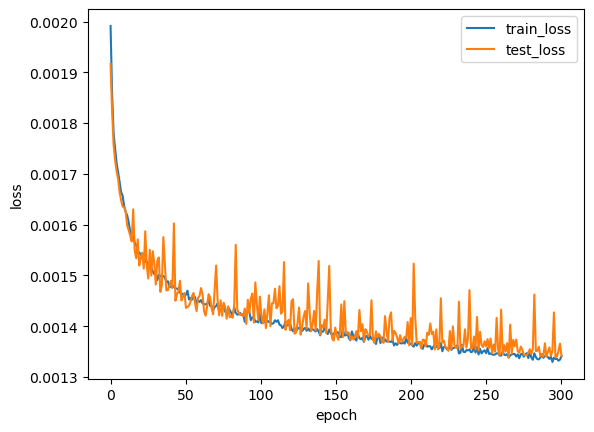

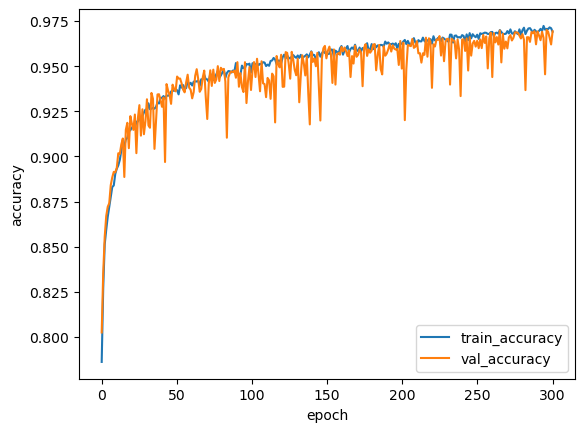

Accuracy on test set : 0.971
test precision: 0.9739464087029495  test recall: 0.9554997566791911  test f1_score: 0.9644925897776139


In [4]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding=0,stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_LN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_LN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

2.ModernICNet -Less Res Connect

epoch1,loss0.0020,train acc 0.786001,val acc 0.808
epoch2,loss0.0019,train acc 0.824549,val acc 0.833
epoch3,loss0.0018,train acc 0.842516,val acc 0.831
epoch4,loss0.0018,train acc 0.850630,val acc 0.849
epoch5,loss0.0018,train acc 0.854808,val acc 0.858
epoch6,loss0.0018,train acc 0.857062,val acc 0.858
epoch7,loss0.0017,train acc 0.859661,val acc 0.864
epoch8,loss0.0017,train acc 0.864023,val acc 0.866
epoch9,loss0.0017,train acc 0.868810,val acc 0.866
epoch10,loss0.0017,train acc 0.871123,val acc 0.871
epoch11,loss0.0017,train acc 0.875000,val acc 0.878
epoch12,loss0.0017,train acc 0.876652,val acc 0.882
epoch13,loss0.0017,train acc 0.880118,val acc 0.883
epoch14,loss0.0017,train acc 0.880992,val acc 0.885
epoch15,loss0.0017,train acc 0.884208,val acc 0.861
epoch16,loss0.0016,train acc 0.886256,val acc 0.891
epoch17,loss0.0016,train acc 0.887805,val acc 0.887
epoch18,loss0.0016,train acc 0.890353,val acc 0.891
epoch19,loss0.0016,train acc 0.891822,val acc 0.895
epoch20,loss0.0016,tr

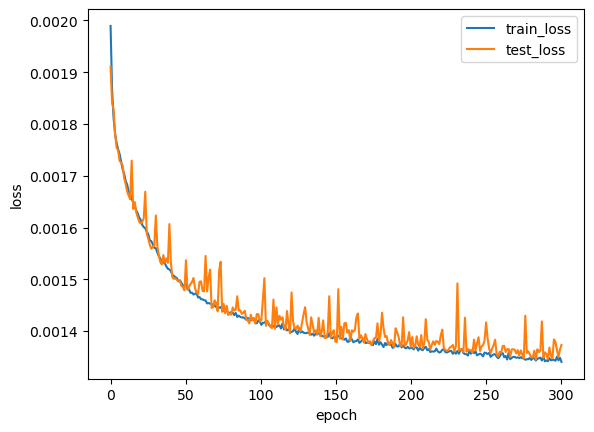

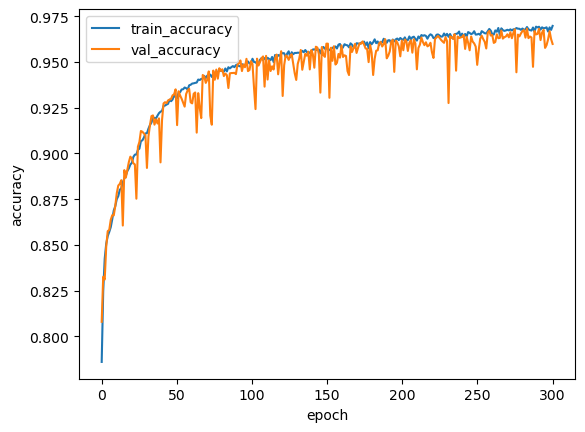

Accuracy on test set : 0.970
test precision: 0.9672515717877297  test recall: 0.9591933120692369  test f1_score: 0.9630773496957065


In [5]:
class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm = nn.LayerNorm(variable_dim*channel_dim)



    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]
        residual = x
        x = rearrange(x, 'b v c s -> b (v c) s')
        y = self.isometric_conv(x)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        z = self.ffn_c(y)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        out = self.ffn_v(z)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        out = out + residual # b v c s
        out = rearrange(out, 'b v c s -> b (v c) s')
        out = out.permute(0,2,1)
        out = self.norm(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (v c) s -> b v c s', v=v)
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_res_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_res_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

3.ModernICNet --BN

epoch1,loss0.0020,train acc 0.785766,val acc 0.807
epoch2,loss0.0019,train acc 0.820680,val acc 0.837
epoch3,loss0.0018,train acc 0.836584,val acc 0.847
epoch4,loss0.0018,train acc 0.844984,val acc 0.849
epoch5,loss0.0018,train acc 0.847686,val acc 0.852
epoch6,loss0.0018,train acc 0.854668,val acc 0.860
epoch7,loss0.0017,train acc 0.860205,val acc 0.862
epoch8,loss0.0017,train acc 0.860278,val acc 0.856
epoch9,loss0.0017,train acc 0.867320,val acc 0.868
epoch10,loss0.0017,train acc 0.869611,val acc 0.871
epoch11,loss0.0017,train acc 0.873862,val acc 0.878
epoch12,loss0.0017,train acc 0.875786,val acc 0.865
epoch13,loss0.0017,train acc 0.878216,val acc 0.861
epoch14,loss0.0017,train acc 0.879090,val acc 0.877
epoch15,loss0.0017,train acc 0.883121,val acc 0.870
epoch16,loss0.0017,train acc 0.884362,val acc 0.874
epoch17,loss0.0016,train acc 0.887343,val acc 0.895
epoch18,loss0.0016,train acc 0.886682,val acc 0.885
epoch19,loss0.0016,train acc 0.892688,val acc 0.884
epoch20,loss0.0016,tr

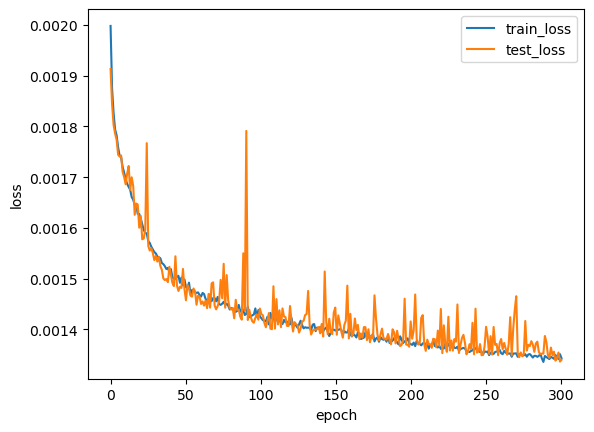

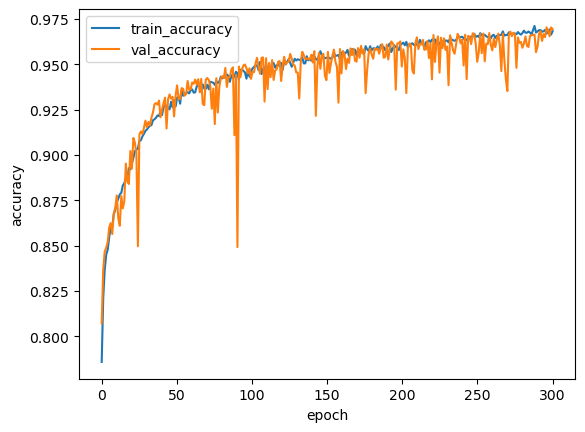

Accuracy on test set : 0.969
test precision: 0.9649425351644307  test recall: 0.9603005127188845  test f1_score: 0.9624513114008845


In [6]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding=0,stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding=0,stride=1,groups=variable_dim*channel_dim)

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_2 = nn.BatchNorm1d(variable_dim*channel_dim)
        self.norm_3 = nn.BatchNorm1d(channel_dim*variable_dim)


    def isometric_conv(self,x):
        #batch_size feature_size seq_len
        zeros = torch.zeros((x.shape[0], x.shape[1], x.shape[2]-1),device='cuda')
        x = torch.cat((zeros, x), dim=-1)
        out = self.conv_s(x)
        return out

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.isometric_conv(x)
        y = self.norm_1(y + residual)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = self.norm_2(z + residual)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = self.norm_3(out + residual)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out



def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernICNet_BN_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernICNet_BN_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

4.ModernCN -- replace Isometric Conv with common Conv1d

epoch1,loss0.0019,train acc 0.799834,val acc 0.827
epoch2,loss0.0018,train acc 0.850960,val acc 0.861
epoch3,loss0.0017,train acc 0.870359,val acc 0.881
epoch4,loss0.0017,train acc 0.882416,val acc 0.889
epoch5,loss0.0016,train acc 0.890919,val acc 0.897
epoch6,loss0.0016,train acc 0.898474,val acc 0.891
epoch7,loss0.0016,train acc 0.905420,val acc 0.912
epoch8,loss0.0016,train acc 0.909584,val acc 0.913
epoch9,loss0.0016,train acc 0.912029,val acc 0.914
epoch10,loss0.0016,train acc 0.911368,val acc 0.919
epoch11,loss0.0015,train acc 0.916074,val acc 0.916
epoch12,loss0.0015,train acc 0.919459,val acc 0.919
epoch13,loss0.0015,train acc 0.920693,val acc 0.915
epoch14,loss0.0015,train acc 0.919518,val acc 0.922
epoch15,loss0.0015,train acc 0.922661,val acc 0.925
epoch16,loss0.0015,train acc 0.922932,val acc 0.912
epoch17,loss0.0015,train acc 0.924114,val acc 0.921
epoch18,loss0.0015,train acc 0.922690,val acc 0.924
epoch19,loss0.0015,train acc 0.924988,val acc 0.930
epoch20,loss0.0015,tr

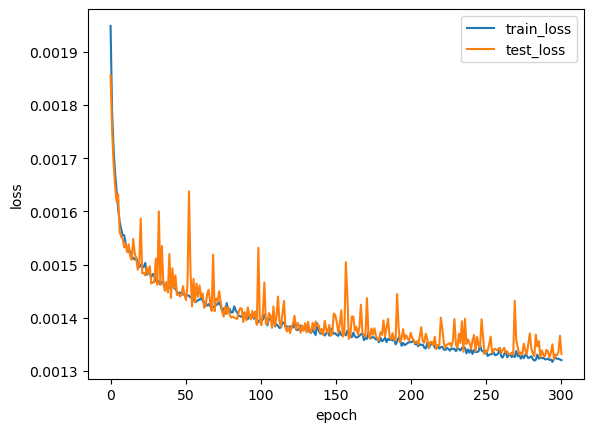

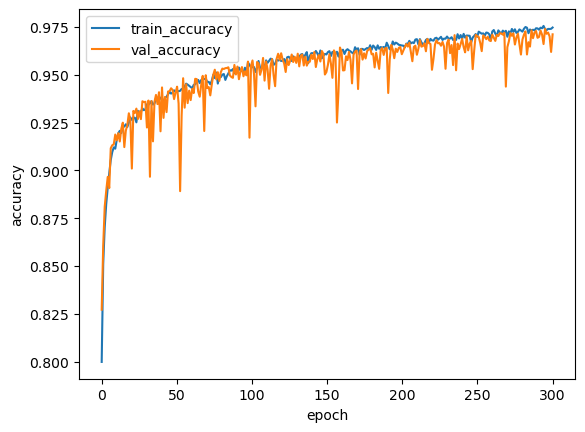

Accuracy on test set : 0.975
test precision: 0.9730356819933932  test recall: 0.9659364161540743  test f1_score: 0.969333379554739


In [14]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=seq_len,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)
        

        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)

epoch1,loss0.0020,train acc 0.791794,val acc 0.797
epoch2,loss0.0018,train acc 0.844580,val acc 0.842
epoch3,loss0.0017,train acc 0.870036,val acc 0.883
epoch4,loss0.0017,train acc 0.884200,val acc 0.894
epoch5,loss0.0016,train acc 0.893709,val acc 0.896
epoch6,loss0.0016,train acc 0.903798,val acc 0.903
epoch7,loss0.0016,train acc 0.908710,val acc 0.916
epoch8,loss0.0015,train acc 0.913571,val acc 0.909
epoch9,loss0.0015,train acc 0.918255,val acc 0.920
epoch10,loss0.0015,train acc 0.921434,val acc 0.925
epoch11,loss0.0015,train acc 0.924996,val acc 0.925
epoch12,loss0.0015,train acc 0.926861,val acc 0.929
epoch13,loss0.0015,train acc 0.930715,val acc 0.929
epoch14,loss0.0015,train acc 0.931376,val acc 0.933
epoch15,loss0.0015,train acc 0.932823,val acc 0.936
epoch16,loss0.0015,train acc 0.933418,val acc 0.930
epoch17,loss0.0015,train acc 0.936244,val acc 0.936
epoch18,loss0.0015,train acc 0.936377,val acc 0.933
epoch19,loss0.0015,train acc 0.938036,val acc 0.940
epoch20,loss0.0015,tr

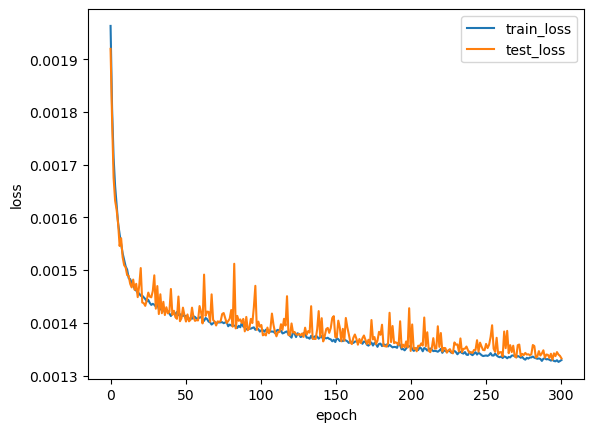

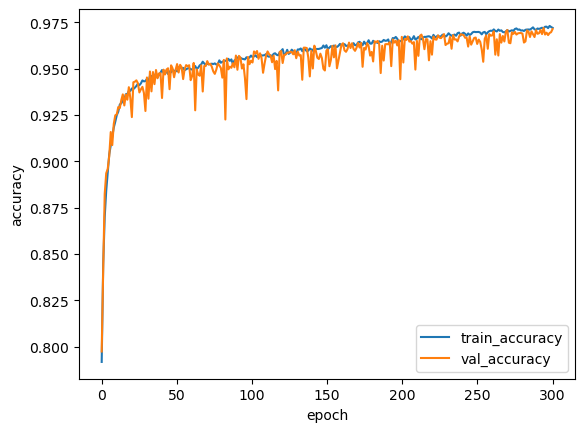

Accuracy on test set : 0.972
test precision: 0.9691680007304734  test recall: 0.9641863365405335  test f1_score: 0.9665238151436784


In [16]:
class Embedding(nn.Module):
    def __init__(self,seq_len,channel_dim):
        super(Embedding,self).__init__()
        self.emb = nn.Conv1d(in_channels=1, out_channels=channel_dim,
                             kernel_size=1,padding='same',stride=1,groups=1)

    def forward(self,x):
        #input b s v
        b = x.shape[0]
        x = x.permute(0,2,1) # b v s
        x = x.unsqueeze(2)#B V 1 S
        x = rearrange(x, 'b v c s -> (b v) c s')# B*V 1 S
        out = self.emb(x) # b v c s
        out = rearrange(out, '(b v) c s -> b v c s', b=b)
        return out # b v c s

class ModernICBlock(nn.Module):
    def __init__(self,variable_dim,r,seq_len,channel_dim):
        super(ModernICBlock,self).__init__()
        #conv_s model seq
        self.conv_s = nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=variable_dim*channel_dim,
                                kernel_size=seq_len,padding='same',stride=1,groups=variable_dim*channel_dim)


        #ffn_c model channel
        self.ffn_c = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=variable_dim),
            nn.Tanh()
        )

        #ffn_v model variable
        self.ffn_v = nn.Sequential(
            nn.Conv1d(in_channels=variable_dim*channel_dim, out_channels=r*variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.GELU(),
            nn.Conv1d(in_channels=r*variable_dim*channel_dim, out_channels=variable_dim*channel_dim,padding='same',kernel_size=1,groups=channel_dim),
            nn.Tanh()
        )

        self.norm_1 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_2 = nn.LayerNorm(variable_dim*channel_dim)
        self.norm_3 = nn.LayerNorm(channel_dim*variable_dim)

    def forward(self,x):
        #input : b v c s
        v = x.shape[1]

        x = rearrange(x, 'b v c s -> b (v c) s')
        residual = x
        y = self.conv_s(x)
        y = y + residual
        y = y.permute(0,2,1)
        y = self.norm_1(y)
        y = y.permute(0,2,1)
        y = rearrange(y,'b (v c) s -> b v c s', v=v)

        y = rearrange(y, 'b v c s -> b (v c) s')
        residual = y
        z = self.ffn_c(y) # 
        z = z + residual
        z = z.permute(0,2,1)
        z = self.norm_2(z)
        z = z.permute(0,2,1)
        z = rearrange(z,'b (v c) s -> b v c s', v=v)
        z = z.permute(0,2,1,3)

        z = rearrange(z, 'b c v s -> b (c v) s')
        residual = z
        out = self.ffn_v(z)
        out = out + residual
        out = out.permute(0,2,1)
        out = self.norm_3(out)
        out = out.permute(0,2,1)
        out = rearrange(out,'b (c v) s -> b c v s',v=v)
        out = out.permute(0,2,1,3)# b v c s
        return out

class ModernICNet(nn.Module):

    def __init__(self,num_block,r,seq_len,channel_dim,variable_dim):
        super(ModernICNet,self).__init__()
        self.pe = PositionalEncoding(variable_dim)
        self.emb = Embedding(seq_len,channel_dim)
        self.ModernICList = nn.ModuleList([ModernICBlock(variable_dim,r,seq_len,channel_dim) for _ in range(num_block)])
        self.linear = nn.Linear(channel_dim*seq_len,seq_len)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=variable_dim*seq_len,out_features=variable_dim*seq_len//2),
            nn.GELU(),
            nn.Linear(in_features=variable_dim*seq_len//2,out_features=2),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self,x):
        x = x+self.pe(x)
        x = self.emb(x) # b v c s
        residual = x # b v c s
        features = x
        for block in self.ModernICList:
            features = block(features)
        features = features + residual
        features = rearrange(features,'b v c s -> b v (c s)')
        features = self.linear(features) # b v s
        features = self.flatten(features) # b (v*s)
        out = self.classifier(features)
        return out

def train(net,train_iter,val_iter,loss,num_epochs,optimizer,device="cuda"):
    net.train()
    train_loss=[]
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]
    val_acc_best = 1e-9
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            #print("X:",X.shape)
            y = y.to(device)
            #print("y:",y.shape) 
            y_hat = net(X)
            #print("y_hat:",y_hat.shape)
            #y_hat = y_hat.squeeze()
            #print("y_hat_squeeze:",y_hat.shape)
            l=loss(y_hat,y.long()).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        net.eval()
        val_acc,val_l = evaluate_accuracy(val_iter,net,loss)
        net.train()
        train_loss.append(train_l_sum/n)
        val_loss.append(val_l)
        train_accuracy.append(train_acc_sum/n)
        val_accuracy.append(val_acc)
        if(val_acc>val_acc_best):
            val_acc_best = val_acc
            train_loss_best = train_l_sum/n
            train_acc_best = train_acc_sum/n
            epoch_best = epoch
            torch.save(net.state_dict(),"weights/ModernCNet2_best.pt")
        print('epoch%d,loss%.4f,train acc %3f,val acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,val_acc))
    print("best weight was found in epoch%d,where the train loss is %.4f,train acc is %3f,val acc is %.3f"%(epoch_best,train_loss_best,train_acc_best,val_acc_best))
    return train_loss,val_loss,train_accuracy,val_accuracy

net = ModernICNet(3,2,100,6,3)
net.to(device)
optimizer=optim.Adam(net.parameters(),lr)

train_loss,val_loss,train_accuracy,val_accuracy=train(net,train_loader,val_loader,loss,epochs,optimizer)
visualization(train_loss,val_loss,train_accuracy,val_accuracy)
net.load_state_dict(torch.load("weights/ModernCNet2_best.pt"))
test_acc,_ = evaluate_accuracy(test_loader,net,loss)
print("Accuracy on test set : %.3f"%(test_acc))

test_precision,test_recall,test_f1_score = evaluate_PR(test_loader,net,loss)
print("test precision:",test_precision," test recall:",test_recall," test f1_score:",test_f1_score)